# 1. Import Required Libraries and Mount Google Drive

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
import glob
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import drive, files

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Set GPU Configuration to Avoid OOM Errors

In [ ]:
# Configure GPU memory growth to avoid out-of-memory errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs available: {len(gpus)}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs available")

No GPUs available


# 3. Define Configuration Parameters

In [ ]:
# Set paths for the dataset
DRIVE_PATH = '/content/drive/MyDrive'
ODD_PLATES_DIR = os.path.join(DRIVE_PATH, 'odd_plates')
EVEN_PLATES_DIR = os.path.join(DRIVE_PATH, 'even_plates')
MODEL_PATH = os.path.join(DRIVE_PATH, 'license_plate_model.h5')

# Model parameters
IMG_SIZE = 224  # Standard input size for many pre-trained models
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001

# 4. Create Directories for Organized Dataset

In [ ]:

def setup_directories():
    """Create directories for training, validation and test datasets"""
    base_dir = '/content/license_plate_dataset'

    # Create main directory if it doesn't exist
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    # Create subdirectories for train, validation, and test sets
    for dataset in ['train', 'validation', 'test']:
        for label in ['odd', 'even']:
            os.makedirs(os.path.join(base_dir, dataset, label), exist_ok=True)

    return base_dir

base_dir = setup_directories()


# 5. Data Preprocessing and Organization

In [ ]:
def organize_dataset(odd_dir, even_dir, base_dir):
    """
    Organize the dataset into train, validation, and test sets
    with an 80/10/10 split
    """
    # Function to split and copy files to appropriate directories
    def copy_files(src_dir, class_name, base_dir):
        files = glob.glob(os.path.join(src_dir, '*'))
        np.random.shuffle(files)  # Shuffle files randomly

        # Calculate split indices
        n_files = len(files)
        n_train = int(0.8 * n_files)
        n_val = int(0.1 * n_files)

        # Split into train, validation, and test sets
        train_files = files[:n_train]
        val_files = files[n_train:n_train+n_val]
        test_files = files[n_train+n_val:]

        # Copy files to respective directories
        for file_list, dataset in [(train_files, 'train'), (val_files, 'validation'), (test_files, 'test')]:
            for file_path in file_list:
                file_name = os.path.basename(file_path)
                dest_path = os.path.join(base_dir, dataset, class_name, file_name)
                # Use a symbolic link to save space
                os.symlink(file_path, dest_path)

        return len(train_files), len(val_files), len(test_files)

    # Process odd and even license plates
    print("Organizing dataset...")
    odd_counts = copy_files(odd_dir, 'odd', base_dir)
    even_counts = copy_files(even_dir, 'even', base_dir)

    print(f"Odd plates: {odd_counts[0]} training, {odd_counts[1]} validation, {odd_counts[2]} test")
    print(f"Even plates: {even_counts[0]} training, {even_counts[1]} validation, {even_counts[2]} test")

    return odd_counts, even_counts

# Organize the dataset
try:
    odd_counts, even_counts = organize_dataset(ODD_PLATES_DIR, EVEN_PLATES_DIR, base_dir)
except Exception as e:
    print(f"Error organizing dataset: {e}")
    print("If you haven't uploaded the odd_plates and even_plates folders to Google Drive, please do so.")
    print("Make sure the paths are correct and the folders contain the license plate images.")


Organizing dataset...
Odd plates: 630 training, 78 validation, 80 test
Even plates: 617 training, 77 validation, 78 test


# 6. Visualize Sample Images from the Dataset

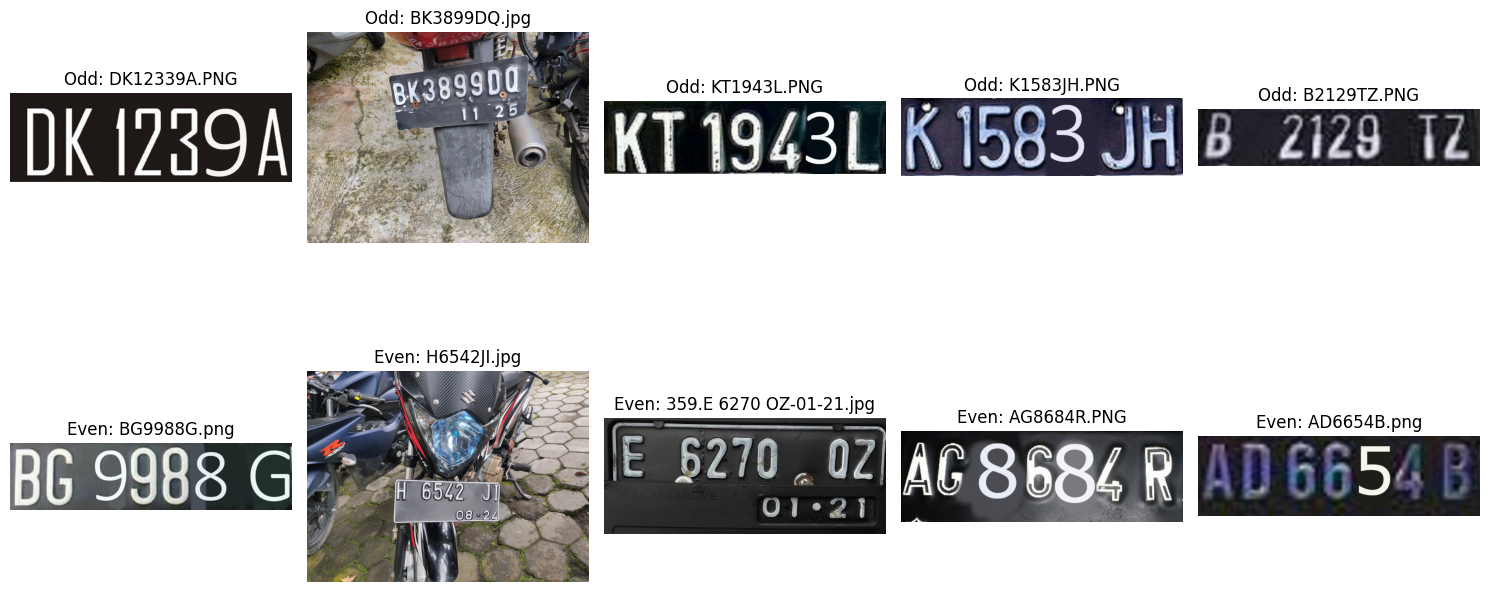

In [ ]:
def visualize_samples(base_dir, num_samples=5):
    """Visualize sample images from the training set"""
    train_odd_dir = os.path.join(base_dir, 'train', 'odd')
    train_even_dir = os.path.join(base_dir, 'train', 'even')

    odd_samples = np.random.choice(os.listdir(train_odd_dir), min(num_samples, len(os.listdir(train_odd_dir))), replace=False)
    even_samples = np.random.choice(os.listdir(train_even_dir), min(num_samples, len(os.listdir(train_even_dir))), replace=False)

    plt.figure(figsize=(15, 8))

    # Plot odd samples
    for i, sample in enumerate(odd_samples):
        img_path = os.path.join(train_odd_dir, sample)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Odd: {sample}")
        plt.axis('off')

    # Plot even samples
    for i, sample in enumerate(even_samples):
        img_path = os.path.join(train_even_dir, sample)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, num_samples, num_samples+i+1)
        plt.imshow(img)
        plt.title(f"Even: {sample}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample images
try:
    visualize_samples(base_dir)
except Exception as e:
    print(f"Error visualizing samples: {e}")

# 7. Data Augmentation and Data Generators

In [ ]:
def create_data_generators():
    """Create data generators with augmentation for training and validation data"""
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=False,  # Don't flip as it might affect number recognition
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    # Validation and test data generator (only rescaling)
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )

    validation_generator = val_test_datagen.flow_from_directory(
        os.path.join(base_dir, 'validation'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(base_dir, 'test'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

# Create data generators
try:
    train_generator, validation_generator, test_generator = create_data_generators()
    class_mapping = {v: k for k, v in train_generator.class_indices.items()}
    print(f"Class mapping: {class_mapping}")
except Exception as e:
    print(f"Error creating data generators: {e}")

Found 1247 images belonging to 2 classes.
Found 155 images belonging to 2 classes.
Found 158 images belonging to 2 classes.
Class mapping: {0: 'even', 1: 'odd'}


# 8. Build the Model

In [ ]:
def build_model():
    """Build a CNN model with transfer learning using MobileNetV2"""
    # Use MobileNetV2 as the base model (efficient and works well on mobile devices)
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Create the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Binary classification (odd or even)
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
try:
    model = build_model()
    model.summary()
except Exception as e:
    print(f"Error building model: {e}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435,393 (9.29 MB)

 Trainable params: 174,849 (683.00 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

# 9. Define Callbacks for Training

In [ ]:
def get_callbacks():
    """Define callbacks for model training"""
    checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        mode='min',
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    return [checkpoint, early_stopping, reduce_lr]

# 10. Train the Model

In [ ]:
def train_model(model, train_generator, validation_generator, callbacks):
    """Train the model using the data generators"""
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    return history

# Train the model
try:
    callbacks = get_callbacks()
    history = train_model(model, train_generator, validation_generator, callbacks)
except Exception as e:
    print(f"Error training model: {e}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4672 - loss: 1.0325
Epoch 1: val_accuracy improved from -inf to 0.48438, saving model to best_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 274s 7s/step - accuracy: 0.4683 - loss: 1.0309 - val_accuracy: 0.4844 - val_loss: 0.8077 - learning_rate: 0.0010
Epoch 2/30
 1/38 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.5312 - loss: 0.8848

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.48438
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - accuracy: 0.5312 - loss: 0.8848 - val_accuracy: 0.4766 - val_loss: 0.8051 - learning_rate: 0.0010
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6001 - loss: 0.7720
Epoch 3: val_accuracy improved from 0.48438 to 0.57812, saving model to best_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.5995 - loss: 0.7724 - val_accuracy: 0.5781 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 4/30
 1/38 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.5312 - loss: 0.8268
Epoch 4: val_accuracy did not improve from 0.57812
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 275ms/step - accuracy: 0.5312 - loss: 0.8268 - val_accuracy: 0.5547 - val_loss: 0.6852 - learning_rate: 0.0010
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5286 - loss: 0.7890
Epoch 5: val_accuracy did not improve from 0.57812
38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.5294 - loss: 0.7886 - val_accuracy: 0.5781 - val_loss: 0.6830 - learning_rate: 0.0010
Epoch 6/30
 1/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5625 - loss: 0.7861
Epoch 6: val_accuracy did not improve from 0.57812

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - accuracy: 0.5625 - loss: 0.7861 - val_accuracy: 0.5

38/38 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.5962 - loss: 0.7047 - val_accuracy: 0.6016 - val_loss: 0.6689 - learning_rate: 2.0000e-04
Epoch 8/30
 1/38 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - accuracy: 0.7188 - loss: 0.5663
Epoch 8: val_accuracy did not improve from 0.60156
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - accuracy: 0.7188 - loss: 0.5663 - val_accuracy: 0.6016 - val_loss: 0.6681 - learning_rate: 2.0000e-04
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6236 - loss: 0.6703
Epoch 9: val_accuracy improved from 0.60156 to 0.64844, saving model to best_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.6235 - loss: 0.6705 - val_accuracy: 0.6484 - val_loss: 0.6527 - learning_rate: 2.0000e-04
Epoch 10/30
 1/38 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.5625 - loss: 0.6853
Epoch 10: val_accuracy did not improve from 0.64844
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 459ms/step - accuracy: 0.5625 - loss: 0.6853 - val_accuracy: 0.6484 - val_loss: 0.6525 - learning_rate: 2.0000e-04
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6082 - loss: 0.6806
Epoch 11: val_accuracy did not improve from 0.64844
38/38 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.6082 - loss: 0.6805 - val_accuracy: 0.6484 - val_loss: 0.6395 - learning_rate: 2.0000e-04
Epoch 12/30
 1/38 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.6875 - loss: 0.6080
Epoch 12: val_accuracy did not improve from 0.64844
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 443ms/step - accuracy: 0.6875 - loss: 0.6080 - val_accuracy: 0.6484 - val_loss: 0.6398 - learning_rate: 2.0000e-04
Epoch 13

# 11. Visualize Training Performance

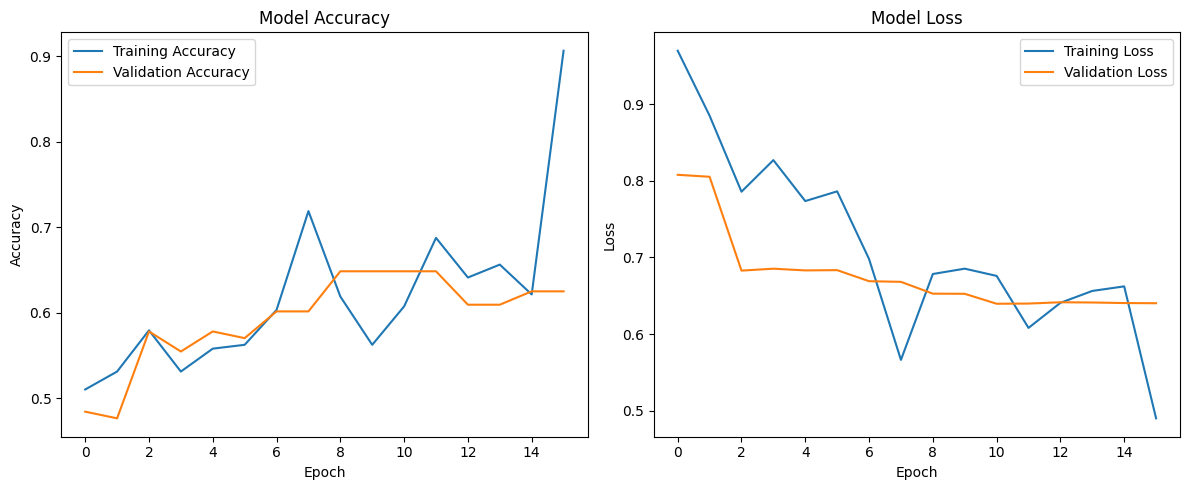

In [ ]:
def plot_training_history(history):
    """Plot the training and validation accuracy/loss"""
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
try:
    plot_training_history(history)
except Exception as e:
    print(f"Error plotting training history: {e}")

# 12. Evaluate the Model on Test Data

In [ ]:
def evaluate_model(model, test_generator):
    """Evaluate the model on the test data"""
    # Get predictions
    test_generator.reset()
    y_pred = model.predict(test_generator, steps=np.ceil(test_generator.samples / BATCH_SIZE))
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Get true labels
    y_true = test_generator.classes

    # Calculate metrics
    accuracy = np.mean(y_pred_classes.flatten() == y_true)
    report = classification_report(y_true, y_pred_classes, target_names=list(class_mapping.values()))

    # Print results
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_mapping.values()), yticklabels=list(class_mapping.values()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return accuracy, report, cm

# Evaluate the model
try:
    accuracy, report, cm = evaluate_model(model, test_generator)
except Exception as e:
    print(f"Error evaluating model: {e}")

Error evaluating model: 'numpy.float64' object cannot be interpreted as an integer


# 13. Save the Final Model

In [ ]:
def save_model(model, path):
    """Save the trained model"""
    model.save(path)
    print(f"Model saved to {path}")

# Save the model
try:
    save_model(model, MODEL_PATH)
except Exception as e:
    print(f"Error saving model: {e}")

Model saved to /content/drive/MyDrive/license_plate_model.h5


# 14. Function to Process and Test on Custom Images

In [ ]:
def test_on_custom_image(model, image_path, class_mapping):
    """
    Test the model on a custom image.

    Args:
        model: Trained model
        image_path: Path to the image
        class_mapping: Dictionary mapping class indices to class names

    Returns:
        prediction: Class prediction (odd or even)
        confidence: Confidence score
    """
    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None, None

    # Convert BGR to RGB (OpenCV loads in BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Normalize the image
    img = img / 255.0

    # Add batch dimension
    img = np.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img)[0][0]

    # Get the class label and confidence
    predicted_class = 'even' if prediction < 0.5 else 'odd'
    confidence = 1 - prediction if prediction < 0.5 else prediction

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img[0])
    plt.title(f"Prediction: {predicted_class.upper()} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

# 15. Function to Allow User to Upload and Test an Image

In [ ]:
def test_uploaded_image(model, class_mapping):
    """Allow the user to upload and test an image"""
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Testing image: {filename}")
        predicted_class, confidence = test_on_custom_image(model, filename, class_mapping)

        if predicted_class is not None:
            print(f"Prediction: {predicted_class.upper()}")
            print(f"Confidence: {confidence:.2f}")

# 16. Sample Usage of Testing Function

In [ ]:
# Uncomment the following line to test on a custom image
# test_on_custom_image(model, '/path/to/your/image.jpg', class_mapping)

# Uncomment the following line to allow user to upload and test an image
# test_uploaded_image(model, class_mapping)

# 18. License Plate Extractor (Advanced Feature)

In [ ]:
def extract_license_plate(image_path):
    """
    Extract license plate from a vehicle image using contour detection.
    This is a simple implementation and might need adjustments for different images.

    Args:
        image_path: Path to the vehicle image

    Returns:
        plate_img: Extracted license plate image or None if not found
    """
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply bilateral filter to remove noise while keeping edges sharp
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Find edges
    edged = cv2.Canny(gray, 30, 200)

    # Find contours
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    plate_contour = None

    # Loop through contours to find rectangle (potential license plate)
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        # If the contour has 4 corners, it's likely a license plate
        if len(approx) == 4:
            plate_contour = approx
            break

    if plate_contour is None:
        print("No license plate found")
        return None

    # Mask the original image to get just the license plate
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [plate_contour], 0, 255, -1)

    # Apply the mask to get the license plate region
    plate_img = cv2.bitwise_and(img, img, mask=mask)

    # Get the bounding rectangle coordinates
    x, y, w, h = cv2.boundingRect(plate_contour)

    # Crop the license plate region
    plate_img = img[y:y+h, x:x+w]

    # Display the extracted license plate
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
    plt.title('Extracted License Plate')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return plate_img

# 19. Complete Pipeline for Image with Vehicle

In [ ]:
def process_vehicle_image(model, image_path, class_mapping):
    """
    Complete pipeline to process a vehicle image:
    1. Extract the license plate
    2. Classify it as odd or even

    Args:
        model: Trained model
        image_path: Path to the vehicle image
        class_mapping: Dictionary mapping class indices to class names

    Returns:
        predicted_class: Predicted class (odd or even)
        confidence: Confidence score
    """
    # Extract license plate
    plate_img = extract_license_plate(image_path)

    if plate_img is None:
        return None, None

    # Save the extracted plate temporarily
    temp_path = 'temp_plate.jpg'
    cv2.imwrite(temp_path, plate_img)

    # Classify the plate
    predicted_class, confidence = test_on_custom_image(model, temp_path, class_mapping)

    # Clean up
    if os.path.exists(temp_path):
        os.remove(temp_path)

    return predicted_class, confidence

# Uncomment to test the complete pipeline on a vehicle image
# process_vehicle_image(model, '/path/to/vehicle/image.jpg', class_mapping)

# 20. Main Function for User Interaction|

In [ ]:
def main():
    """Main function for user interaction"""
    print("\n===== Indonesian License Plate Odd/Even Classifier =====")
    print("1. Test on a custom license plate image")
    print("2. Test on a vehicle image (extract license plate first)")
    print("3. Upload and test your own image")
    print("4. Exit")

    choice = input("\nEnter your choice (1-4): ")

    if choice == '1':
        image_path = input("Enter the path to the license plate image: ")
        if os.path.exists(image_path):
            test_on_custom_image(model, image_path, class_mapping)
        else:
            print(f"Error: File not found at {image_path}")

    elif choice == '2':
        image_path = input("Enter the path to the vehicle image: ")
        if os.path.exists(image_path):
            process_vehicle_image(model, image_path, class_mapping)
        else:
            print(f"Error: File not found at {image_path}")

    elif choice == '3':
        test_uploaded_image(model, class_mapping)

    elif choice == '4':
        print("Exiting program.")
        return

    else:
        print("Invalid choice. Please try again.")

    # Recursive call to continue program
    main()

# Call the main function at the end to start user interaction
# main()

Saving plat-nomor-rfs-artinya-apa-ramai-dibahas-terkait-rachel-vennya.jpeg to plat-nomor-rfs-artinya-apa-ramai-dibahas-terkait-rachel-vennya.jpeg
Testing image: plat-nomor-rfs-artinya-apa-ramai-dibahas-terkait-rachel-vennya.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


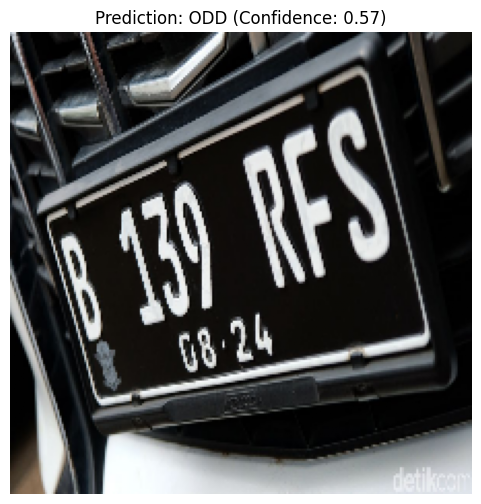

Prediction: ODD
Confidence: 0.57


In [ ]:
test_uploaded_image(model, class_mapping)

Saving ilustrasi-plat-b1231zz-pelat-b1231zz_169.jpeg to ilustrasi-plat-b1231zz-pelat-b1231zz_169.jpeg
Testing image: ilustrasi-plat-b1231zz-pelat-b1231zz_169.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


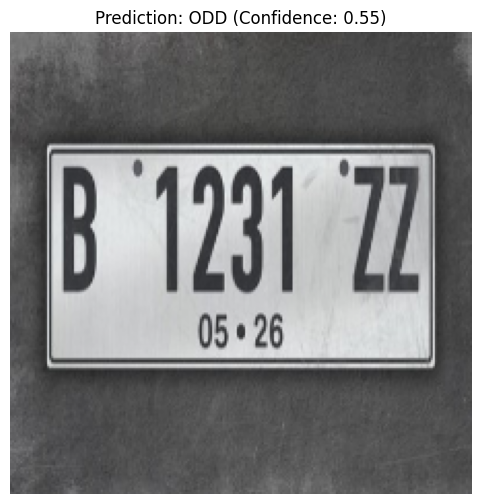

Prediction: ODD
Confidence: 0.55


In [ ]:
test_uploaded_image(model, class_mapping)

Saving test_license_plate.png to test_license_plate.png
Testing image: test_license_plate.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


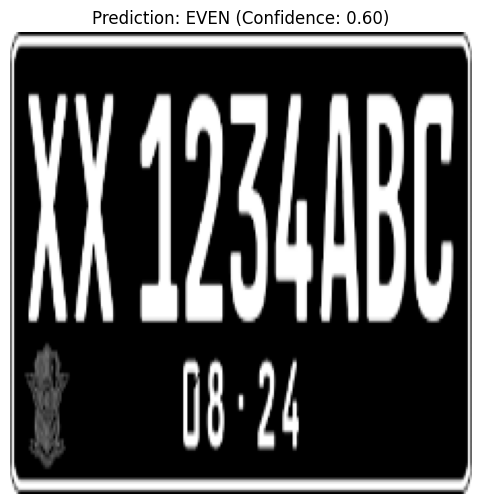

Prediction: EVEN
Confidence: 0.60


In [ ]:
test_uploaded_image(model, class_mapping)

Saving AG3121R.jpg to AG3121R.jpg
Testing image: AG3121R.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


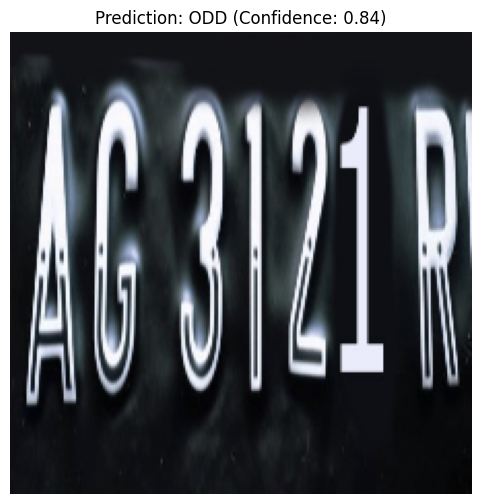

Prediction: ODD
Confidence: 0.84


In [ ]:
test_uploaded_image(model, class_mapping)

Saving test_license3.png to test_license3.png
Testing image: test_license3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


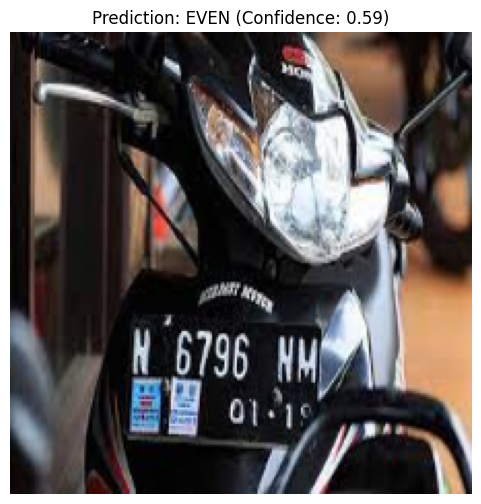

Prediction: EVEN
Confidence: 0.59


In [ ]:
test_uploaded_image(model, class_mapping)

Saving test_license_plate2.jpg to test_license_plate2.jpg
Testing image: test_license_plate2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


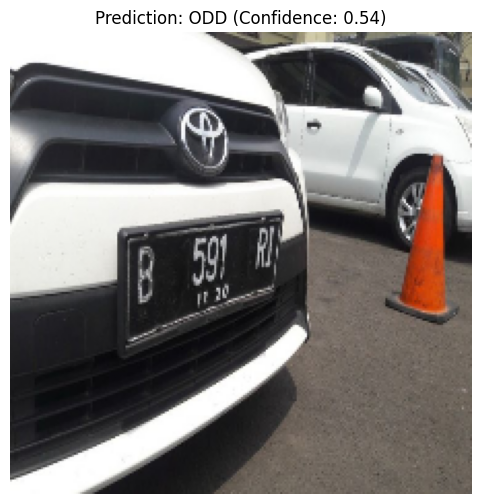

Prediction: ODD
Confidence: 0.54


In [ ]:
test_uploaded_image(model, class_mapping)